# Customer Review Patterns Analysis and Buying Decision Classification using Gradient Boosting Algorithms Optimized with Grey Wolf Algorithm

This notebook analyzes customer review patterns and predicts buying decisions using gradient boosting algorithms optimized with the Grey Wolf Optimization algorithm.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

## Grey Wolf Optimization Algorithm Implementation

In [2]:
def grey_wolf_optimizer(func, bounds, n_wolves=10, max_iter=100):
    """
    Grey Wolf Optimizer implementation
    """
    n_vars = len(bounds)
    alpha_pos, alpha_score = np.zeros(n_vars), float('inf')
    beta_pos, beta_score = np.zeros(n_vars), float('inf')
    delta_pos, delta_score = np.zeros(n_vars), float('inf')

    # Initialize wolves
    positions = np.zeros((n_wolves, n_vars))
    for i in range(n_vars):
        positions[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], n_wolves)

    for iteration in range(max_iter):
        print(f"GWO Iteration {iteration + 1}/{max_iter}...", end=" ")

        for i in range(n_wolves):
            # Calculate objective function for each wolf
            score = func(positions[i, :])

            # Update alpha, beta, delta
            if score < alpha_score:
                alpha_score = score
                alpha_pos = positions[i, :].copy()

            if score < beta_score and score > alpha_score:
                beta_score = score
                beta_pos = positions[i, :].copy()

            if score < delta_score and score > alpha_score and score > beta_score:
                delta_score = score
                delta_pos = positions[i, :].copy()

        a = 2 - iteration * (2 / max_iter)  # a decreases linearly from 2 to 0

        # Update positions
        for i in range(n_wolves):
            for j in range(n_vars):
                r1, r2 = np.random.random(), np.random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha_pos[j] - positions[i, j])
                X1 = alpha_pos[j] - A1 * D_alpha

                r1, r2 = np.random.random(), np.random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta_pos[j] - positions[i, j])
                X2 = beta_pos[j] - A2 * D_beta

                r1, r2 = np.random.random(), np.random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta_pos[j] - positions[i, j])
                X3 = delta_pos[j] - A3 * D_delta

                positions[i, j] = (X1 + X2 + X3) / 3.0

                # Bound checking
                positions[i, j] = np.clip(positions[i, j], bounds[j][0], bounds[j][1])

        print(f"Best score so far: {-alpha_score:.4f}")

    return alpha_pos, alpha_score

## Load and Explore the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('data/Customer_Review (1).csv')

print("Original Dataset Info:")
print(df.head())
print(f"\nDataset Shape: {df.shape}")
print(f"Target Distribution:\n{df['Purchased'].value_counts()}")

Original Dataset Info:
   Serial Number  Age  Gender   Review Education Purchased
0              1   56    Male     Poor        PG       Yes
1              2   46  Female     Good    School       Yes
2              3   32  Female     Good        PG        No
3              4   25  Female  Average        PG       Yes
4              5   38    Male     Poor        UG        No

Dataset Shape: (100, 6)
Target Distribution:
Purchased
No     56
Yes    44
Name: count, dtype: int64


## Feature Engineering

In [4]:
# Feature Engineering
df = df.drop('Serial Number', axis=1)  # Drop ID column

# Create age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 60], labels=['Young', 'Adult', 'Middle', 'Senior'])

# Create feature combinations
df['Gender_Review'] = df['Gender'].astype(str) + '_' + df['Review'].astype(str)
df['Review_Edu'] = df['Review'].astype(str) + '_' + df['Education'].astype(str)

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Gender', 'Review', 'Education', 'Age_Group', 'Gender_Review', 'Review_Edu']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print(f"Dataset after feature engineering:\n{df.head()}")

Dataset after feature engineering:
   Age  Gender  Review  Education Purchased  Age_Group  Gender_Review  \
0   56       1       2          0       Yes          2              5   
1   46       0       1          1       Yes          1              1   
2   32       0       1          0        No          0              1   
3   25       0       0          0       Yes          3              0   
4   38       1       2          2        No          1              5   

   Review_Edu  
0           6  
1           4  
2           3  
3           0  
4           8  


## Data Preprocessing

In [5]:
# Separate features and target
X = df.drop('Purchased', axis=1)
y = df['Purchased']

# Encode target variable
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Scale numerical features
scaler = StandardScaler()
X[['Age']] = scaler.fit_transform(X[['Age']])

# Use SMOTE to generate synthetic samples
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print(f"Augmented dataset shape: {X_smote.shape}")
print(f"Augmented target distribution:\n{pd.Series(y_smote).value_counts()}")

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

Augmented dataset shape: (112, 7)
Augmented target distribution:
1    56
0    56
Name: count, dtype: int64


## Define Objective Functions for GWO Optimization

In [6]:
def xgb_objective(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2]
    reg_alpha = params[3]
    reg_lambda = params[4]

    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )

    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_sm)
    # Return negative accuracy to maximize (GWO minimizes)
    return -accuracy_score(y_test_sm, y_pred)

def lgb_objective(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2]
    reg_alpha = params[3]
    reg_lambda = params[4]

    model = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        verbose=-1
    )

    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_sm)
    # Return negative accuracy to maximize (GWO minimizes)
    return -accuracy_score(y_test_sm, y_pred)

def cat_objective(params):
    iterations = int(params[0])
    depth = int(params[1])
    learning_rate = params[2]
    reg_lambda = params[3]

    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        random_state=42,
        verbose=False
    )

    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_sm)
    # Return negative accuracy to maximize (GWO minimizes)
    return -accuracy_score(y_test_sm, y_pred)

## Optimize Models using Grey Wolf Optimization

In [7]:
print("\n" + "="*50)
print("GREY WOLF OPTIMIZATION FOR HYPERPARAMETER TUNING")
print("="*50)

# Optimize XGBoost
print("\nOptimizing XGBoost with Grey Wolf Optimization...")
xgb_bounds = [
    [50, 200],      # n_estimators
    [3, 10],        # max_depth
    [0.01, 0.3],    # learning_rate
    [0.0, 1.0],     # reg_alpha
    [0.0, 2.0]      # reg_lambda
]
best_xgb_params, best_xgb_score = grey_wolf_optimizer(xgb_objective, xgb_bounds, max_iter=20)
# Convert best_xgb_score back to positive accuracy
best_xgb_acc = -best_xgb_score
print(f"Best XGBoost parameters: n_estimators={int(best_xgb_params[0])}, max_depth={int(best_xgb_params[1])}, "
      f"learning_rate={best_xgb_params[2]:.3f}, reg_alpha={best_xgb_params[3]:.3f}, reg_lambda={best_xgb_params[4]:.3f}")
print(f"Best XGBoost accuracy: {best_xgb_acc:.4f}")


GREY WOLF OPTIMIZATION FOR HYPERPARAMETER TUNING

Optimizing XGBoost with Grey Wolf Optimization...
GWO Iteration 1/20... Best score so far: 0.7391
GWO Iteration 2/20... Best score so far: 0.7826
GWO Iteration 3/20... Best score so far: 0.7826
GWO Iteration 4/20... Best score so far: 0.7826
GWO Iteration 5/20... Best score so far: 0.7826
GWO Iteration 6/20... Best score so far: 0.8261
GWO Iteration 7/20... Best score so far: 0.8261
GWO Iteration 8/20... Best score so far: 0.8261
GWO Iteration 9/20... Best score so far: 0.8261
GWO Iteration 10/20... Best score so far: 0.8261
GWO Iteration 11/20... Best score so far: 0.8261
GWO Iteration 12/20... Best score so far: 0.8261
GWO Iteration 13/20... Best score so far: 0.8261
GWO Iteration 14/20... Best score so far: 0.8261
GWO Iteration 15/20... Best score so far: 0.8261
GWO Iteration 16/20... Best score so far: 0.8261
GWO Iteration 17/20... Best score so far: 0.8261
GWO Iteration 18/20... Best score so far: 0.8261
GWO Iteration 19/20... Bes

In [8]:
# Optimize LightGBM
print("\nOptimizing LightGBM with Grey Wolf Optimization...")
lgb_bounds = [
    [50, 200],      # n_estimators
    [3, 10],        # max_depth
    [0.01, 0.3],    # learning_rate
    [0.0, 1.0],     # reg_alpha
    [0.0, 2.0]      # reg_lambda
]
best_lgb_params, best_lgb_score = grey_wolf_optimizer(lgb_objective, lgb_bounds, max_iter=20)
# Convert best_lgb_score back to positive accuracy
best_lgb_acc = -best_lgb_score
print(f"Best LightGBM parameters: n_estimators={int(best_lgb_params[0])}, max_depth={int(best_lgb_params[1])}, "
      f"learning_rate={best_lgb_params[2]:.3f}, reg_alpha={best_lgb_params[3]:.3f}, reg_lambda={best_lgb_params[4]:.3f}")
print(f"Best LightGBM accuracy: {best_lgb_acc:.4f}")


Optimizing LightGBM with Grey Wolf Optimization...
GWO Iteration 1/20... Best score so far: 0.6957
GWO Iteration 2/20... Best score so far: 0.7391
GWO Iteration 3/20... Best score so far: 0.7391
GWO Iteration 4/20... Best score so far: 0.7391
GWO Iteration 5/20... Best score so far: 0.7391
GWO Iteration 6/20... Best score so far: 0.7391
GWO Iteration 7/20... Best score so far: 0.7391
GWO Iteration 8/20... Best score so far: 0.7391
GWO Iteration 9/20... Best score so far: 0.7391
GWO Iteration 10/20... Best score so far: 0.7391
GWO Iteration 11/20... Best score so far: 0.7391
GWO Iteration 12/20... Best score so far: 0.7391
GWO Iteration 13/20... Best score so far: 0.7391
GWO Iteration 14/20... Best score so far: 0.7391
GWO Iteration 15/20... Best score so far: 0.7391
GWO Iteration 16/20... Best score so far: 0.7391
GWO Iteration 17/20... Best score so far: 0.7391
GWO Iteration 18/20... Best score so far: 0.7391
GWO Iteration 19/20... Best score so far: 0.7391
GWO Iteration 20/20... Bes

In [9]:
# Optimize CatBoost
print("\nOptimizing CatBoost with Grey Wolf Optimization...")
cat_bounds = [
    [50, 200],      # iterations
    [3, 10],        # depth
    [0.01, 0.3],    # learning_rate
    [0.0, 2.0]      # reg_lambda
]
best_cat_params, best_cat_score = grey_wolf_optimizer(cat_objective, cat_bounds, max_iter=20)
# Convert best_cat_score back to positive accuracy
best_cat_acc = -best_cat_score
print(f"Best CatBoost parameters: iterations={int(best_cat_params[0])}, depth={int(best_cat_params[1])}, "
      f"learning_rate={best_cat_params[2]:.3f}, reg_lambda={best_cat_params[3]:.3f}")
print(f"Best CatBoost accuracy: {best_cat_acc:.4f}")


Optimizing CatBoost with Grey Wolf Optimization...
GWO Iteration 1/20... Best score so far: 0.8261
GWO Iteration 2/20... Best score so far: 0.8696
GWO Iteration 3/20... Best score so far: 0.8696
GWO Iteration 4/20... Best score so far: 0.8696
GWO Iteration 5/20... Best score so far: 0.8696
GWO Iteration 6/20... Best score so far: 0.8696
GWO Iteration 7/20... Best score so far: 0.8696
GWO Iteration 8/20... Best score so far: 0.8696
GWO Iteration 9/20... Best score so far: 0.8696
GWO Iteration 10/20... Best score so far: 0.8696
GWO Iteration 11/20... Best score so far: 0.8696
GWO Iteration 12/20... Best score so far: 0.8696
GWO Iteration 13/20... Best score so far: 0.8696
GWO Iteration 14/20... Best score so far: 0.8696
GWO Iteration 15/20... Best score so far: 0.8696
GWO Iteration 16/20... Best score so far: 0.8696
GWO Iteration 17/20... Best score so far: 0.8696
GWO Iteration 18/20... Best score so far: 0.8696
GWO Iteration 19/20... Best score so far: 0.8696
GWO Iteration 20/20... Bes

## Train Models with Optimized Parameters

In [10]:
print("\n" + "="*50)
print("TRAINING MODELS WITH OPTIMIZED PARAMETERS")
print("="*50)

# XGBoost with optimized parameters
xgb_optimized = xgb.XGBClassifier(
    n_estimators=int(best_xgb_params[0]),
    max_depth=int(best_xgb_params[1]),
    learning_rate=best_xgb_params[2],
    reg_alpha=best_xgb_params[3],
    reg_lambda=best_xgb_params[4],
    random_state=42
)
xgb_optimized.fit(X_train_sm, y_train_sm)
xgb_pred = xgb_optimized.predict(X_test_sm)
xgb_accuracy = accuracy_score(y_test_sm, xgb_pred)
print(f"XGBoost Optimized Accuracy: {xgb_accuracy:.4f}")

# LightGBM with optimized parameters
lgb_optimized = lgb.LGBMClassifier(
    n_estimators=int(best_lgb_params[0]),
    max_depth=int(best_lgb_params[1]),
    learning_rate=best_lgb_params[2],
    reg_alpha=best_lgb_params[3],
    reg_lambda=best_lgb_params[4],
    random_state=42,
    verbose=-1
)
lgb_optimized.fit(X_train_sm, y_train_sm)
lgb_pred = lgb_optimized.predict(X_test_sm)
lgb_accuracy = accuracy_score(y_test_sm, lgb_pred)
print(f"LightGBM Optimized Accuracy: {lgb_accuracy:.4f}")

# CatBoost with optimized parameters
cat_optimized = CatBoostClassifier(
    iterations=int(best_cat_params[0]),
    depth=int(best_cat_params[1]),
    learning_rate=best_cat_params[2],
    reg_lambda=best_cat_params[3],
    random_state=42,
    verbose=False
)
cat_optimized.fit(X_train_sm, y_train_sm)
cat_pred = cat_optimized.predict(X_test_sm)
cat_accuracy = accuracy_score(y_test_sm, cat_pred)
print(f"CatBoost Optimized Accuracy: {cat_accuracy:.4f}")


TRAINING MODELS WITH OPTIMIZED PARAMETERS
XGBoost Optimized Accuracy: 0.8261
LightGBM Optimized Accuracy: 0.7391
CatBoost Optimized Accuracy: 0.8696


## Model Performance Comparison

In [11]:
# Collect all results
all_accuracies = [xgb_accuracy, lgb_accuracy, cat_accuracy]
all_model_names = ['XGBoost', 'LightGBM', 'CatBoost']

print(f"\nAll accuracies: {all_accuracies}")
best_idx = np.argmax(all_accuracies)
best_model_name = all_model_names[best_idx]
best_accuracy = all_accuracies[best_idx]

print(f"\nBest Model: {best_model_name} with {best_accuracy:.4f} accuracy")


All accuracies: [0.8260869565217391, 0.7391304347826086, 0.8695652173913043]

Best Model: CatBoost with 0.8696 accuracy


In [12]:
# Calculate detailed metrics for each model
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_data = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

all_predictions = [xgb_pred, lgb_pred, cat_pred]

for i, name in enumerate(all_model_names):
    y_pred = all_predictions[i]
    y_true = y_test_sm

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    metrics_data['Model'].append(name)
    metrics_data['Accuracy'].append(accuracy)
    metrics_data['Precision'].append(precision)
    metrics_data['Recall'].append(recall)
    metrics_data['F1-Score'].append(f1)

metrics_df = pd.DataFrame(metrics_data)
print(f"\nDetailed Metrics Comparison:\n{metrics_df}")


Detailed Metrics Comparison:
      Model  Accuracy  Precision    Recall  F1-Score
0   XGBoost  0.826087   0.835059  0.826087  0.824080
1  LightGBM  0.739130   0.768634  0.739130  0.728778
2  CatBoost  0.869565   0.895652  0.869565  0.866514


## Visualization and Results

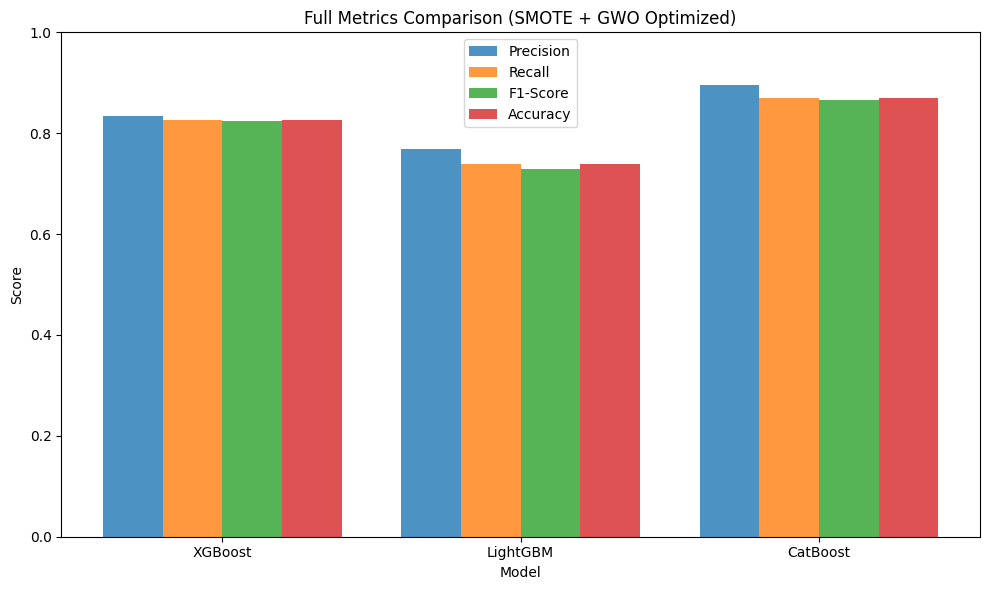

In [13]:
# Create directory for saving figures
results_dir = r"results"
os.makedirs(results_dir, exist_ok=True)

# 1. Full metric comparison
plt.figure(figsize=(10, 6))
x_pos_metrics = np.arange(len(metrics_df['Model']))
width_metric = 0.2

plt.bar(x_pos_metrics - width_metric*1.5, metrics_df['Precision'], width_metric, label='Precision', alpha=0.8)
plt.bar(x_pos_metrics - width_metric/2, metrics_df['Recall'], width_metric, label='Recall', alpha=0.8)
plt.bar(x_pos_metrics + width_metric/2, metrics_df['F1-Score'], width_metric, label='F1-Score', alpha=0.8)
plt.bar(x_pos_metrics + width_metric*1.5, metrics_df['Accuracy'], width_metric, label='Accuracy', alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Full Metrics Comparison (SMOTE + GWO Optimized)')
plt.xticks(x_pos_metrics, metrics_df['Model'])
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'full_metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

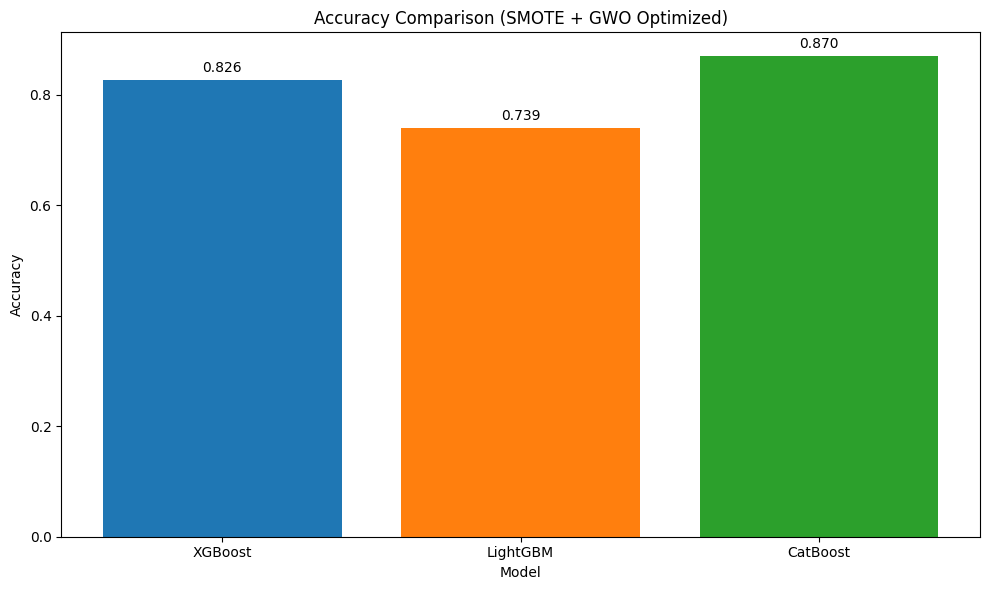

In [14]:
# 2. Accuracy comparison specifically
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Model'], metrics_df['Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison (SMOTE + GWO Optimized)')
for i, v in enumerate(metrics_df['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'accuracy_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

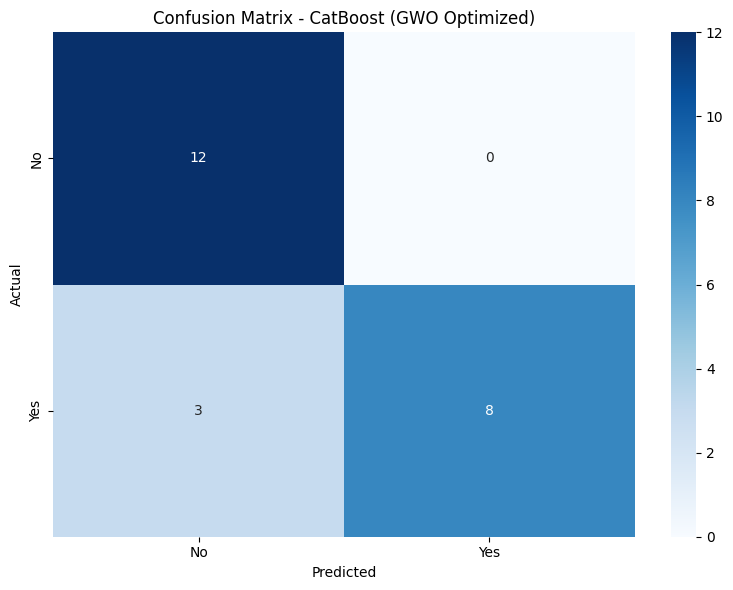

In [15]:
# 3. Best model detailed results
best_model_obj = [xgb_optimized, lgb_optimized, cat_optimized][best_idx]
best_X_test = X_test_sm
best_y_test = y_test_sm
y_pred_best = best_model_obj.predict(best_X_test)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(best_y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name} (GWO Optimized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'confusion_matrix_{best_model_name.lower()}.png'), dpi=300, bbox_inches='tight')
plt.show()

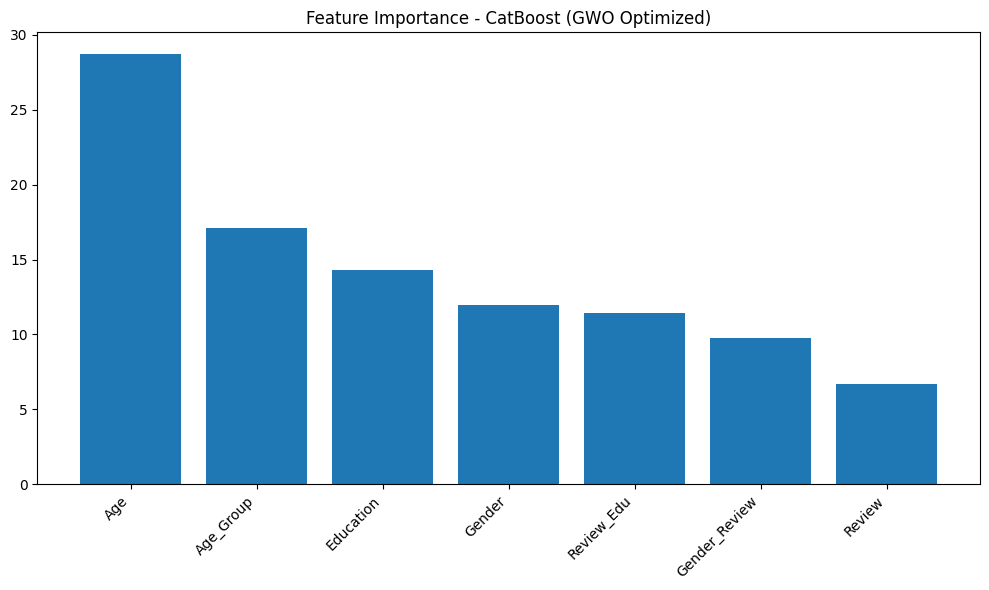

In [16]:
# 4. Feature importance for best model
feature_names = X.columns.tolist()

# Get feature importances for the best model
if best_model_name == 'XGBoost':
    importances = best_model_obj.feature_importances_
elif best_model_name == 'LightGBM':
    importances = best_model_obj.feature_importances_
elif best_model_name == 'CatBoost':
    importances = best_model_obj.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.title(f'Feature Importance - {best_model_name} (GWO Optimized)')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'feature_importance_{best_model_name.lower()}.png'), dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Detailed classification report for best model
print(f"\nDetailed Classification Report for {best_model_name} (GWO Optimized):")
print(classification_report(best_y_test, y_pred_best, target_names=target_encoder.classes_))


Detailed Classification Report for CatBoost (GWO Optimized):
              precision    recall  f1-score   support

          No       0.80      1.00      0.89        12
         Yes       1.00      0.73      0.84        11

    accuracy                           0.87        23
   macro avg       0.90      0.86      0.87        23
weighted avg       0.90      0.87      0.87        23



## Final Summary

In [18]:
# Final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

print("\nModel Performance (SMOTE + GWO Optimized):")
for model_name, acc in zip(all_model_names, all_accuracies):
    print(f"- {model_name}: {acc:.4f}")

print("\nRECOMMENDATION: The augmented dataset with SMOTE and GWO optimization helped improve performance.")

# Save metrics dataframe to CSV
metrics_df.to_csv(os.path.join(results_dir, 'model_metrics_comparison.csv'), index=False)
print(f"\nModel metrics saved to: {os.path.join(results_dir, 'model_metrics_comparison.csv')}")

# Save the best model
import joblib
best_model = [xgb_optimized, lgb_optimized, cat_optimized][best_idx]
joblib.dump(best_model, os.path.join(results_dir, f'best_model_{best_model_name.lower()}.pkl'))
print(f"Best model saved to: {os.path.join(results_dir, f'best_model_{best_model_name.lower()}.pkl')}")


FINAL SUMMARY
Best Model: CatBoost
Best Accuracy: 0.8696

Model Performance (SMOTE + GWO Optimized):
- XGBoost: 0.8261
- LightGBM: 0.7391
- CatBoost: 0.8696

RECOMMENDATION: The augmented dataset with SMOTE and GWO optimization helped improve performance.

Model metrics saved to: results\model_metrics_comparison.csv
Best model saved to: results\best_model_catboost.pkl
